In [88]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def to_screen(name, file):
    cv.imshow(name, file)  
    cv.waitKey(0)
    cv.destroyAllWindows()  

# Exercise 1


### Assignment 1


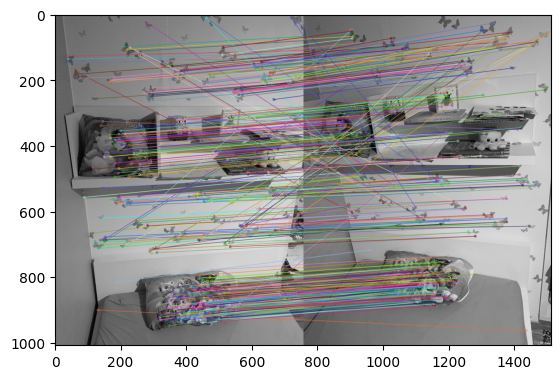

(<matplotlib.image.AxesImage at 0x22bde7bec80>, None)

In [89]:
### source: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
### and https://docs.opencv.org/4.x/da/de9/tutorial_py_epipolar_geometry.html

img1 = cv.imread('../afbeeldingen/im00.png',cv.IMREAD_GRAYSCALE) # queryImage
img2 = cv.imread('../afbeeldingen/im01.png',cv.IMREAD_GRAYSCALE) # trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []

good = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        good.append([m])


# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

### Assignment 2

the term "inlier point" is typically used to describe a point in one image that can be accurately matched with a corresponding point in the other image, based on some feature descriptor and matching algorithm.

In [90]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F_ass2, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

### find epilines


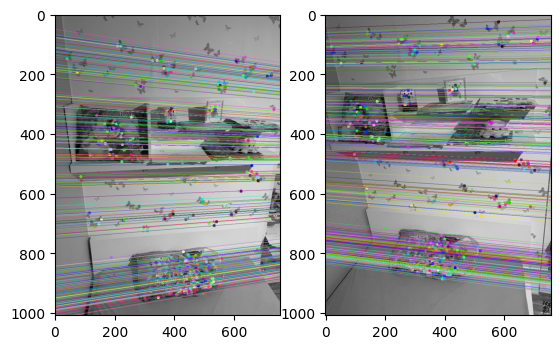

In [38]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

# Exercise 2

### Assignment 3
E = C'.T * FC

camera used for both images have the same calibration matrix

In [118]:
C = np.array([[792, 0, 505],
              [0, 791, 376],
              [0, 0, 1]], dtype="float32")


E_ass3 = np.matmul(C.T,np.matmul(F_ass2,C))
E_ass3


array([[   4.6707871 ,  118.95862644,  -18.1845254 ],
       [  54.64252453,  -27.51502493, -363.8500133 ],
       [  11.25858838,  407.47929868,  -30.97639495]])

### Assignment 4
we first apply the inverse camera matrix to the image coordinates of each
camera, resulting in what we call normalized coordinates

With normalised coordinates the fundamental matrix is automatically the essential matrix


In [117]:
I = np.linalg.inv(C)

# Convert the keypoints to homogeneous coordinates
pts1_homog = np.hstack((pts1, np.ones((len(pts1), 1))))
pts2_homog = np.hstack((pts2, np.ones((len(pts2), 1))))


# Normalize the keypoints
pts1_norm = np.matmul(pts1_homog, I)
pts2_norm = np.matmul(pts2_homog, I)

test = pts1_homog @ I

# Compute the essential matrix (met genorm)
F, mask = cv.findFundamentalMat(pts1_norm,pts2_norm,cv.FM_LMEDS)
F

array([[ 2.11603416e+05,  3.28540474e+05,  4.39972331e+02],
       [-8.23933846e+02,  1.26554783e+05,  1.38637537e+01],
       [ 4.84038165e+02,  6.98784682e+02,  1.00000000e+00]])

In [107]:
one = np.ones((pts1.shape[0], 1))
pts1x = np.append(pts1, one, axis=1)
pts2x = np.append(pts2, one, axis=1)

Cacc = np.linalg.inv(C)
norm1 = pts1x@np.transpose(Cacc)
norm2 = pts2x@np.transpose(Cacc)

E_ass4, _  = cv.findFundamentalMat(norm1, norm2,cv.FM_LMEDS)
E_ass4

array([[-1.94987346e-03, -2.90136255e+00,  1.82404533e-01],
       [-3.04826143e+00,  1.01212012e+00,  1.25036364e+01],
       [-4.01206281e-02, -1.38876903e+01,  1.00000000e+00]])

### Assignment 5
x'.T * Fx

x point of left epipolar line (pts1)


x' point of right epipolar line (pts2)


In [113]:
# 1) original coo and F from Assigment 2
result1 = np.matmul(pts2_homog,np.matmul(F_ass2,pts1_homog.T))

# 2) norm coo and E from Assigment 3
result3 = np.matmul(norm2,np.matmul(E_ass3,norm1.T))

# 3) norm coo and # from Assignment 4
result4 = np.matmul(norm2,np.matmul(E_ass4,norm1.T))


mean1 = np.mean(result1)
mean2 = np.mean(result3)
mean3 = np.mean(result4)

print(f"mean1: {mean1}")
print(f"mean2: {mean2}")
print(f"mean3: {mean3}")

mean1: 2.867126870074971
mean2: 2.8671272466010294
mean3: -0.12225555622674995


### Assignment 6

In [ ]:
_,R,t,_ = cv.recoverPose(E_ass3, pts1, pts2, C)